In [1]:
import scenicplus
import muon as mu
import pycisTopic
import pandas as pd
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
import matplotlib.pyplot as plt
import os
import pickle
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.pseudobulk_peak_calling import peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.lda_models import evaluate_models




out_dir = "chen_outs"
os.makedirs(out_dir, exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)

/data/adrienne/phd/biohackathon_2025/scenicplus/src/scenicplus/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-05 18:35:18,838	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
print(pycisTopic.__version__)
print(scenicplus.__version__)

2.0a0
1.0a2


In [3]:
res_folder = 'analysis_chen/results/chen_2024/'
samples = os.listdir(res_folder)

In [4]:
fragments_dict = {sample : f'analysis_chen/results/chen_2024/{sample}/outs/atac_fragments.tsv.gz' for sample in samples}

In [5]:
mdata = mu.read_h5mu('analysis_chen/integration_test_3.h5mu')

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
mdata.obs

,rna:sample,rna:age,rna:majorclass,rna:subclass,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:scDblFinder_score,rna:scDblFinder_class,...,atac:scDblFinder_score,atac:scDblFinder_class,atac:_scvi_batch,atac:_scvi_labels,atac:leiden,sample,_indices,_scvi_batch,_scvi_labels,leiden
AAACAGCCAAACTGTT-1_chen_10wk_central,chen_10wk_central,10wk,PRPC,PRPC,2913,5635.0,16.0,0.283940,0.000021,singlet,...,0.000714,singlet,0,0,11,chen_10wk_central,0,0,0,6
AAACAGCCAATGAGGT-1_chen_10wk_central,chen_10wk_central,10wk,RGC,RGC Precursor,3241,7922.0,109.0,1.375915,0.000021,singlet,...,0.140442,singlet,0,0,7,chen_10wk_central,1,0,0,8
AAACAGCCAGCTTAGC-1_chen_10wk_central,chen_10wk_central,10wk,PRPC,PRPC,4068,9670.0,11.0,0.113754,0.000028,singlet,...,0.002203,singlet,0,0,1,chen_10wk_central,2,0,0,6
AAACATGCAGCTTACA-1_chen_10wk_central,chen_10wk_central,10wk,RGC,OFF_MGC,4060,11122.0,18.0,0.161841,0.000021,singlet,...,0.002927,singlet,0,0,16,chen_10wk_central,3,0,0,15
AAACATGCATGTTGTG-1_chen_10wk_central,chen_10wk_central,10wk,RGC,RGC Precursor,4331,12910.0,84.0,0.650658,0.000021,singlet,...,0.024031,singlet,0,0,16,chen_10wk_central,4,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCTAGCGTG-1_chen_20wk2d_central,chen_20wk2d_central,20wk2d,AC,GABAergic,3032,7746.0,46.0,0.593855,0.000062,singlet,...,0.000342,singlet,0,0,5,chen_20wk2d_central,38505,6,0,16
TTTGTGTTCTCAATAG-1_chen_20wk2d_central,chen_20wk2d_central,20wk2d,Rod,Rod Precursor,1749,3186.0,4.0,0.125549,0.000021,singlet,...,0.000413,singlet,0,0,14,chen_20wk2d_central,38506,6,0,4
TTTGTTGGTACAAAGA-1_chen_20wk2d_central,chen_20wk2d_central,NaN,NaN,NaN,2448,5973.0,6.0,0.100452,0.000028,singlet,...,0.004614,singlet,0,0,15,chen_20wk2d_central,38507,6,0,13
TTTGTTGGTCAAGTAT-1_chen_20wk2d_central,chen_20wk2d_central,20wk2d,Rod,Rod,3736,10123.0,16.0,0.158056,0.000084,singlet,...,0.012636,singlet,0,0,14,chen_20wk2d_central,38508,6,0,4


In [7]:
cell_data = mdata.obs
cell_data.head()

,rna:sample,rna:age,rna:majorclass,rna:subclass,rna:n_genes_by_counts,rna:total_counts,rna:total_counts_mt,rna:pct_counts_mt,rna:scDblFinder_score,rna:scDblFinder_class,...,atac:scDblFinder_score,atac:scDblFinder_class,atac:_scvi_batch,atac:_scvi_labels,atac:leiden,sample,_indices,_scvi_batch,_scvi_labels,leiden
AAACAGCCAAACTGTT-1_chen_10wk_central,chen_10wk_central,10wk,PRPC,PRPC,2913,5635.0,16.0,0.283940,0.000021,singlet,...,0.000714,singlet,0,0,11,chen_10wk_central,0,0,0,6
AAACAGCCAATGAGGT-1_chen_10wk_central,chen_10wk_central,10wk,RGC,RGC Precursor,3241,7922.0,109.0,1.375915,0.000021,singlet,...,0.140442,singlet,0,0,7,chen_10wk_central,1,0,0,8
AAACAGCCAGCTTAGC-1_chen_10wk_central,chen_10wk_central,10wk,PRPC,PRPC,4068,9670.0,11.0,0.113754,0.000028,singlet,...,0.002203,singlet,0,0,1,chen_10wk_central,2,0,0,6
AAACATGCAGCTTACA-1_chen_10wk_central,chen_10wk_central,10wk,RGC,OFF_MGC,4060,11122.0,18.0,0.161841,0.000021,singlet,...,0.002927,singlet,0,0,16,chen_10wk_central,3,0,0,15
AAACATGCATGTTGTG-1_chen_10wk_central,chen_10wk_central,10wk,RGC,RGC Precursor,4331,12910.0,84.0,0.650658,0.000021,singlet,...,0.024031,singlet,0,0,16,chen_10wk_central,4,0,0,8


In [8]:
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes.head()

,Chromosome,Start,End
0,chr1,0,248956422
1,chr2,0,242193529
2,chr3,0,198295559
3,chr4,0,190214555
4,chr5,0,181538259


In [ ]:
bw_paths, bed_paths = export_pseudobulk(
    input_data = cell_data,
    variable = "atac:majorclass",
    sample_id_col = "rna:sample",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 10,
    normalize_bigwig = True,
    temp_dir = "/tmp",
    split_pattern = "_"
)

2025-09-05 18:35:31,625 cisTopic     INFO     Splitting fragments by cell type.
2025-09-05 18:40:48,402 cisTopic     INFO     generating bigwig files


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://set

In [10]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [11]:
bw_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bw_paths.update({v: p})

    
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

In [12]:
macs_path = "macs3"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'hs',
    n_cpu = 10,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05#,
    #_temp_dir = '/scratch/leuven/330/vsc33053/ray_spill'
)

2025-09-05 18:43:40,900	INFO worker.py:1724 -- Started a local Ray instance.
(pid=24547) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(pid=24547)   from pkg_resources import DistributionNotFound, get_distribution


(macs_call_peak_ray pid=24552) 2025-09-05 18:43:42,706 cisTopic     INFO     Calling peaks for HC with macs3 callpeak --treatment chen_outs/consensus_peak_calling/pseudobulk_bed_files/HC.fragments.tsv.gz --name HC  --outdir chen_outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=24548) 2025-09-05 18:43:42,764 cisTopic     INFO     Calling peaks for Rod with macs3 callpeak --treatment chen_outs/consensus_peak_calling/pseudobulk_bed_files/Rod.fragments.tsv.gz --name Rod  --outdir chen_outs/consensus_peak_calling/MACS --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=24546) 2025-09-05 18:43:42,924 cisTopic     INFO     Calling peaks for NRPC with macs3 callpeak --treatment chen_outs/consensus_peak_calling/pseudobulk_bed_files/NRPC.fragments.tsv.gz --name NRPC  --outdir chen_outs/c

(pid=24545) /home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81. [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(pid=24545)   from pkg_resources import DistributionNotFound, get_distribution [repeated 9x across cluster]


In [13]:
# Other param
peak_half_width=250
path_to_blacklist="pycisTopic/blacklist/hg38-blacklist.v2.bed"
# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2025-09-05 18:50:32,990 cisTopic     INFO     Extending and merging peaks per class


2025-09-05 18:52:41,799 cisTopic     INFO     Normalizing peak scores
2025-09-05 18:52:42,603 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2025-09-05 18:54:22,226 cisTopic     INFO     Done!


In [14]:
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version

In [15]:
!pycistopic tss gene_annotation_list | grep Human

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
hsapiens_gene_ensembl	Human genes (GRCh38.p14)


In [30]:
!mkdir -p chen_outs/qc


In [31]:
!pycistopic tss get_tss \
    --output chen_outs/qc/tss.bed \
    --name "hsapiens_gene_ensembl" \
    --to-chrom-source ucsc \
    --ucsc hg38

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
- Get TSS annotation from Ensembl BioMart with the following settings:
  - biomart_name: "hsapiens_gene_ensembl"
  - biomart_host: "http://www.ensembl.org"
  - transcript_type: ['protein_coding']
  - use_cache: True
- Getting chromosome sizes and alias mapping for "hg38" from UCSC.
- Update chromosome names in TSS annotation to "ucsc" chromosome names.
- Writing TSS annotation BED file to "chen_outs/qc/tss.bed".


In [32]:
!head outs/qc/tss.bed | column -t

#     Chromosome  Start  End      Gene  Score  Strand          Transcript_type
chrM  3306        3307   MT-ND1   .     +      protein_coding  
chrM  4469        4470   MT-ND2   .     +      protein_coding  
chrM  5903        5904   MT-CO1   .     +      protein_coding  
chrM  7585        7586   MT-CO2   .     +      protein_coding  
chrM  8365        8366   MT-ATP8  .     +      protein_coding  
chrM  8526        8527   MT-ATP6  .     +      protein_coding  
chrM  9206        9207   MT-CO3   .     +      protein_coding  
chrM  10058       10059  MT-ND3   .     +      protein_coding  
chrM  10469       10470  MT-ND4L  .     +      protein_coding  


In [33]:
fragments_dict

{'chen_10wk_central': 'analysis_chen/results/chen_2024/chen_10wk_central/outs/atac_fragments.tsv.gz',
 'chen_20wk2d_peripheral': 'analysis_chen/results/chen_2024/chen_20wk2d_peripheral/outs/atac_fragments.tsv.gz',
 'chen_16wk4d_central': 'analysis_chen/results/chen_2024/chen_16wk4d_central/outs/atac_fragments.tsv.gz',
 'chen_10wk_peripheral': 'analysis_chen/results/chen_2024/chen_10wk_peripheral/outs/atac_fragments.tsv.gz',
 'chen_16wk4d_peripheral': 'analysis_chen/results/chen_2024/chen_16wk4d_peripheral/outs/atac_fragments.tsv.gz',
 'chen_12wk3d_central': 'analysis_chen/results/chen_2024/chen_12wk3d_central/outs/atac_fragments.tsv.gz',
 'chen_12wk3d_peripheral': 'analysis_chen/results/chen_2024/chen_12wk3d_peripheral/outs/atac_fragments.tsv.gz',
 'chen_20wk2d_central': 'analysis_chen/results/chen_2024/chen_20wk2d_central/outs/atac_fragments.tsv.gz'}

In [34]:
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
tss_bed_filename = os.path.join(out_dir, "qc", "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc')}/{sample}",
            sep=" ",
            file=fh,
        )

In [35]:
!bash pycistopic_qc_commands.txt 

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://set

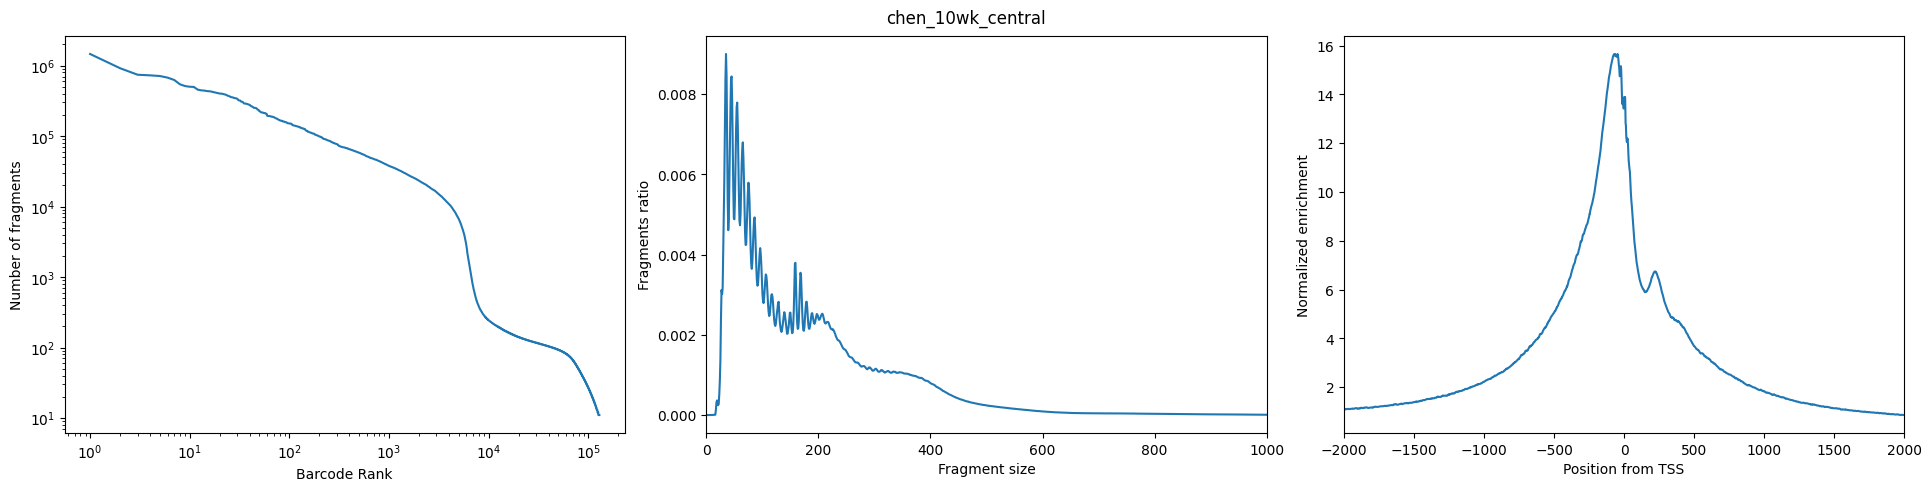

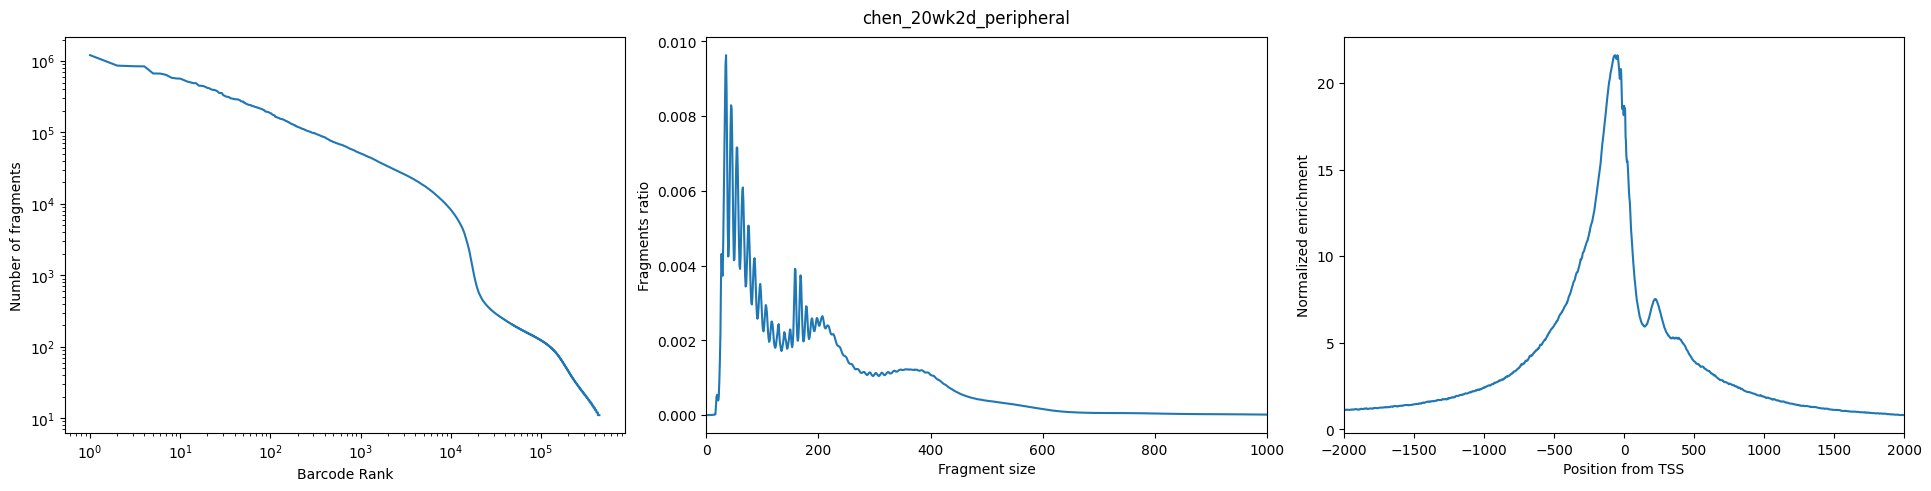

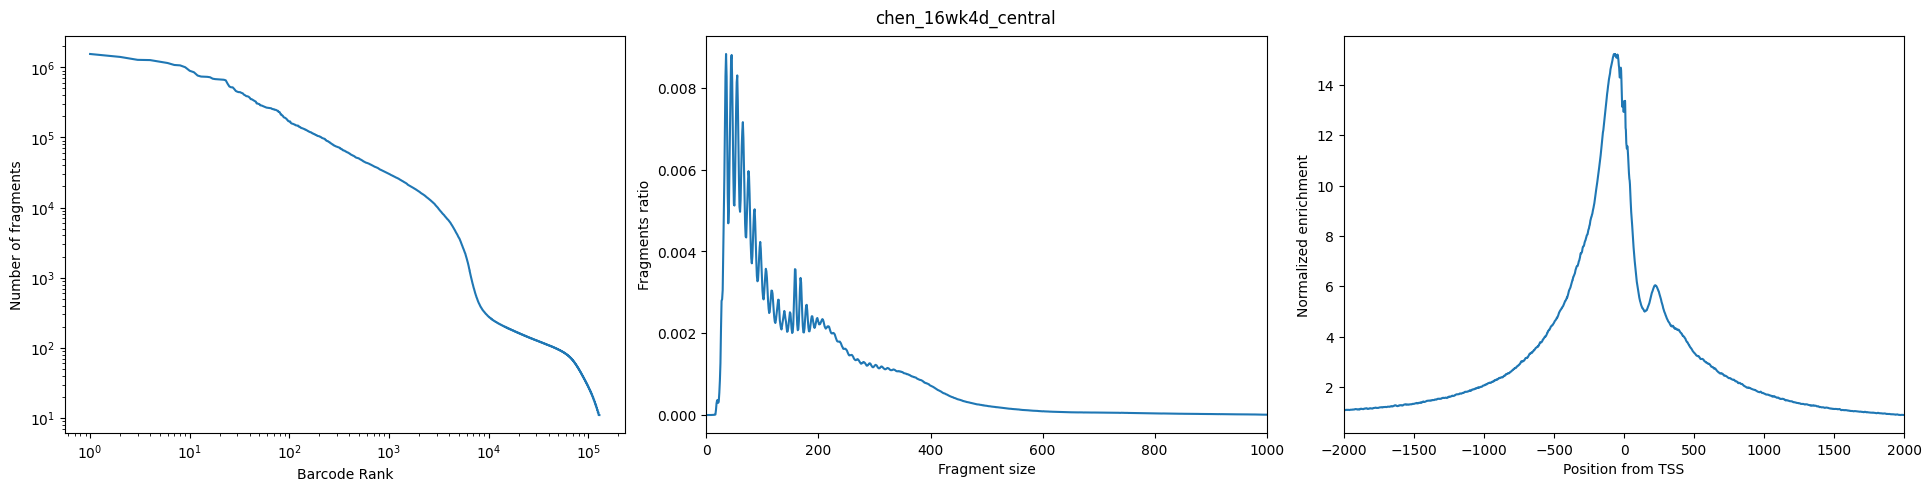

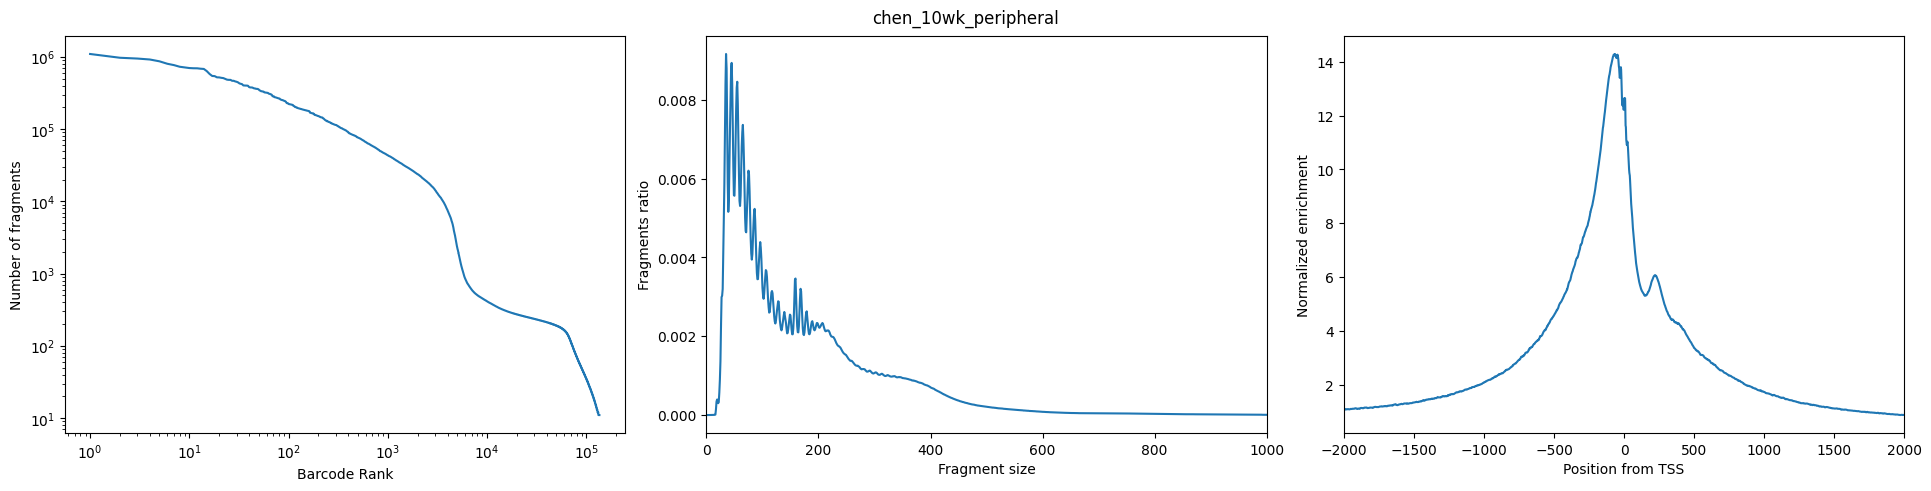

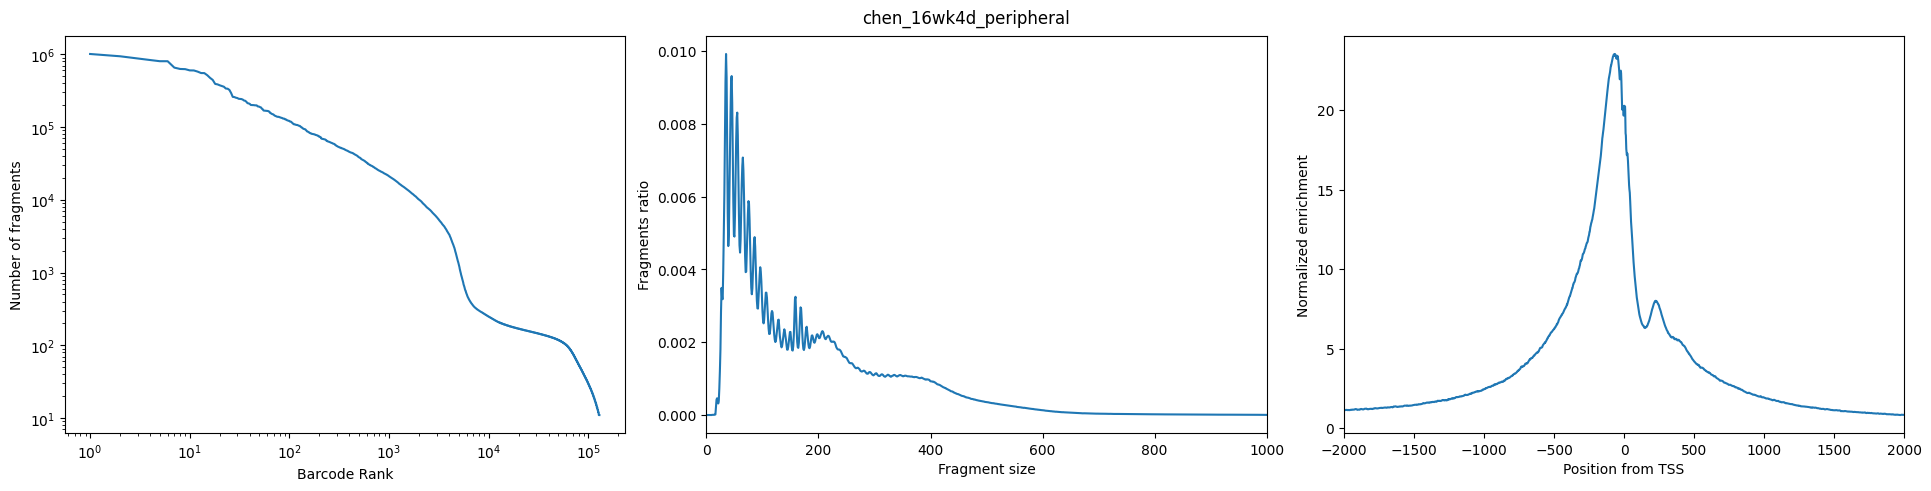

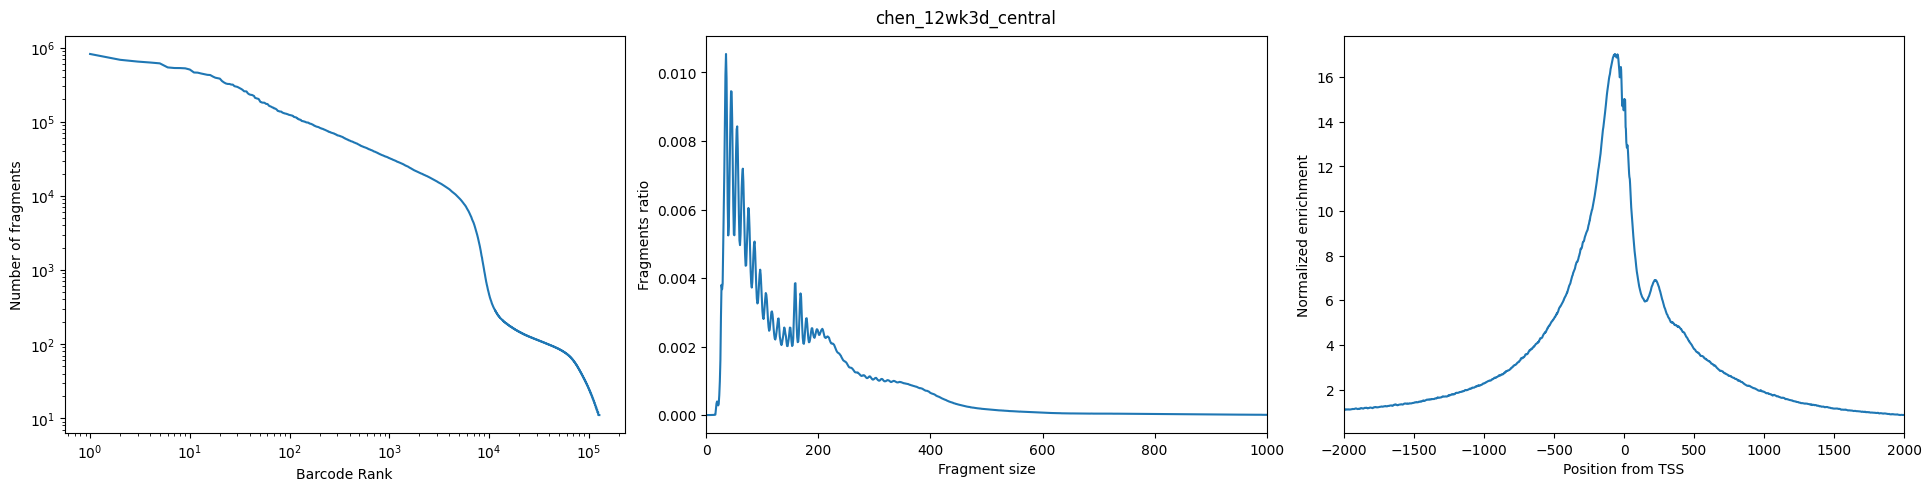

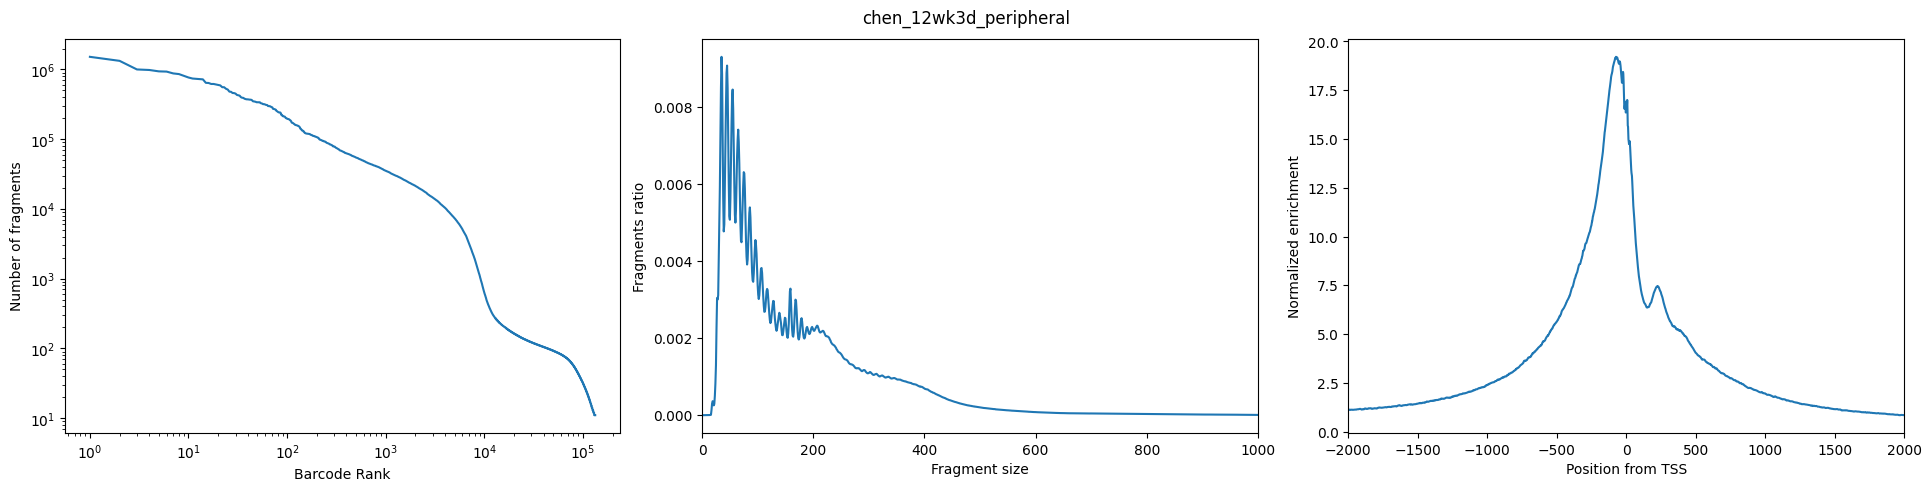

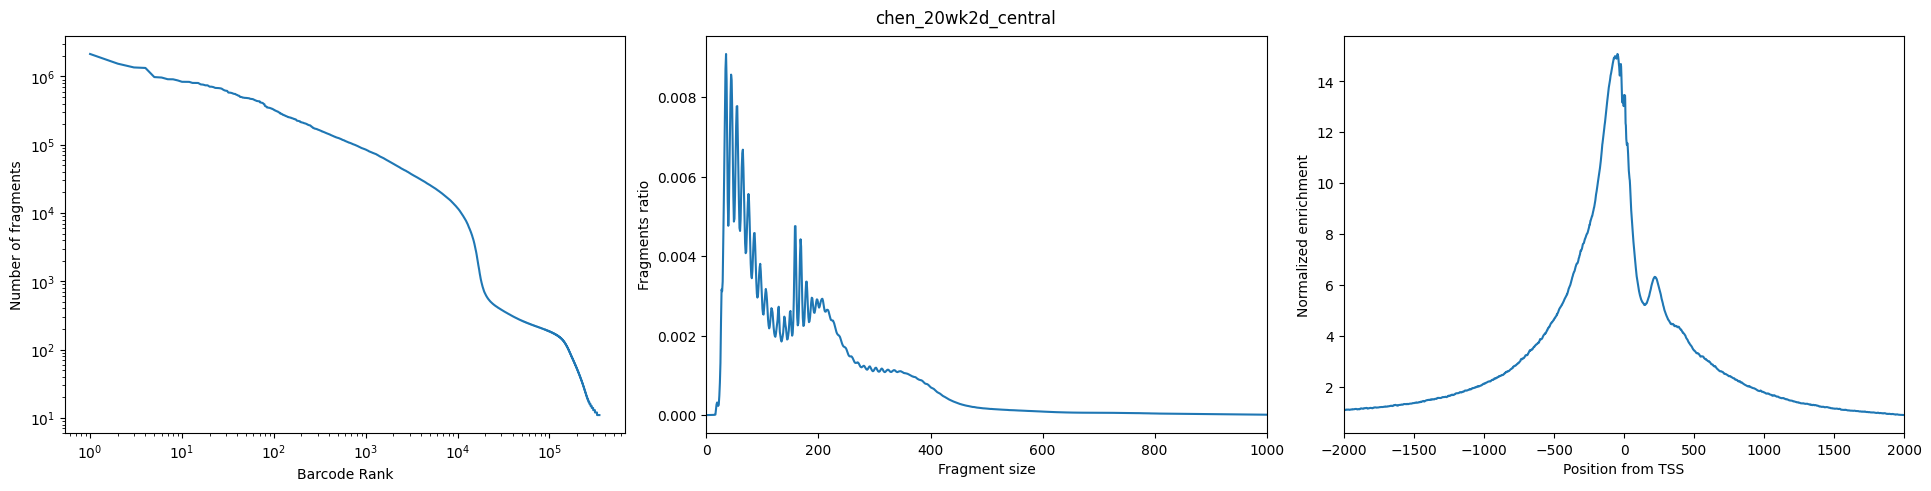

In [36]:
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "chen_outs/qc"
    )

In [37]:
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id = sample_id,
            pycistopic_qc_output_dir = "chen_outs/qc",
            unique_fragments_threshold = None, # use automatic thresholding
            tss_enrichment_threshold = None, # use automatic thresholding
            frip_threshold = 0,
            use_automatic_thresholds = True,
    )

chen_10wk_central:
	Using automatic threshold for unique fragments: 1365.0019391795377
	Using automatic threshold for TSS enrichment: 8.353072825801519
chen_20wk2d_peripheral:
	Using automatic threshold for unique fragments: 1048.9589997101932
	Using automatic threshold for TSS enrichment: 11.524460120564296
chen_16wk4d_central:
	Using automatic threshold for unique fragments: 1183.5336201653738
	Using automatic threshold for TSS enrichment: 10.009734429261613
chen_10wk_peripheral:
	Using automatic threshold for unique fragments: 1302.3062577360085
	Using automatic threshold for TSS enrichment: 8.069792486112377
chen_16wk4d_peripheral:
	Using automatic threshold for unique fragments: 1080.0058227049433
	Using automatic threshold for TSS enrichment: 12.960386138613861
chen_12wk3d_central:
	Using automatic threshold for unique fragments: 1234.0412945442679
	Using automatic threshold for TSS enrichment: 8.817879702970297
chen_12wk3d_peripheral:
	Using automatic threshold for unique fragme

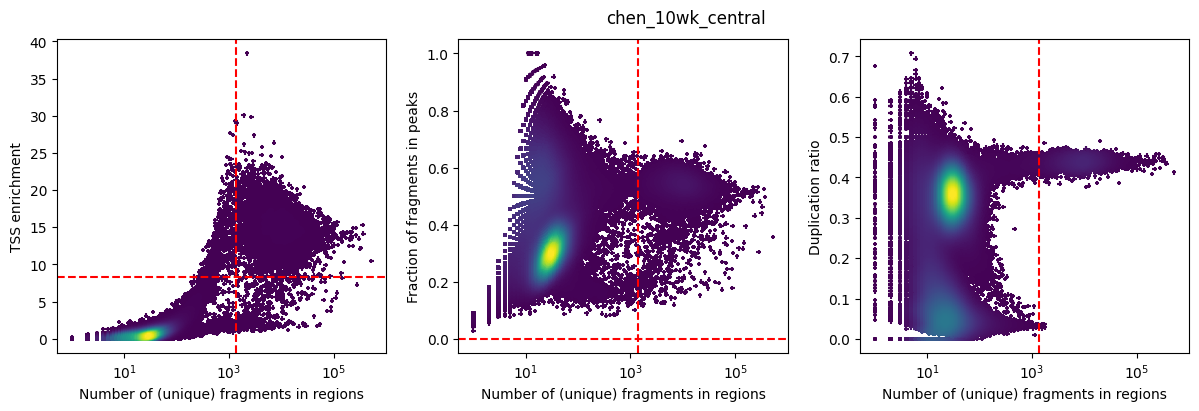

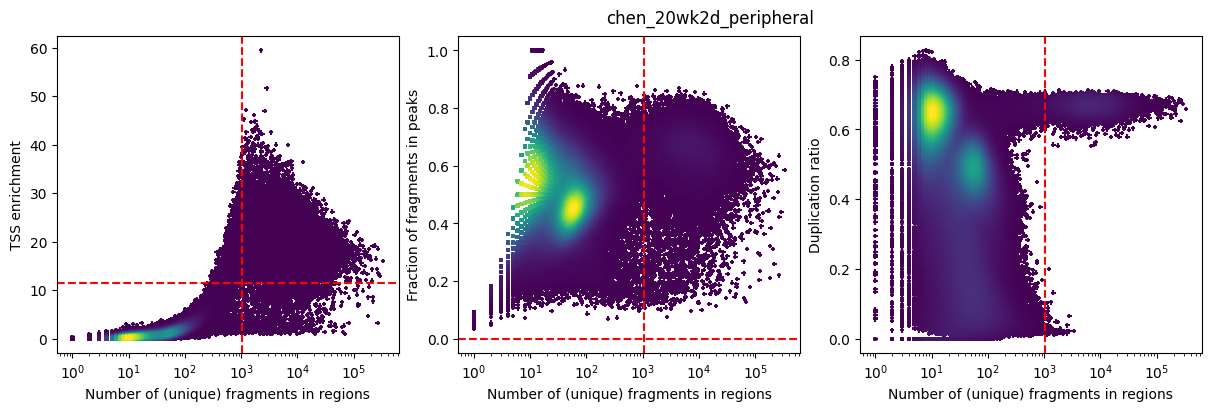

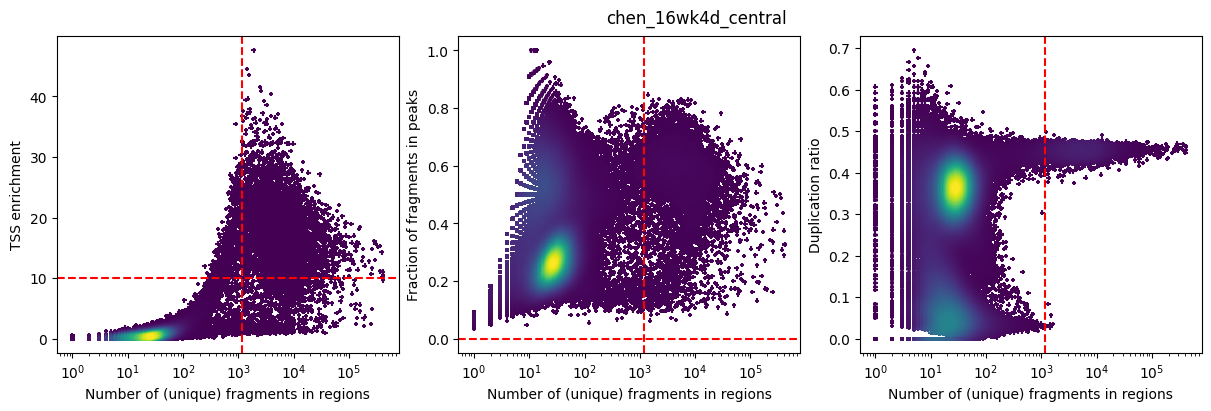

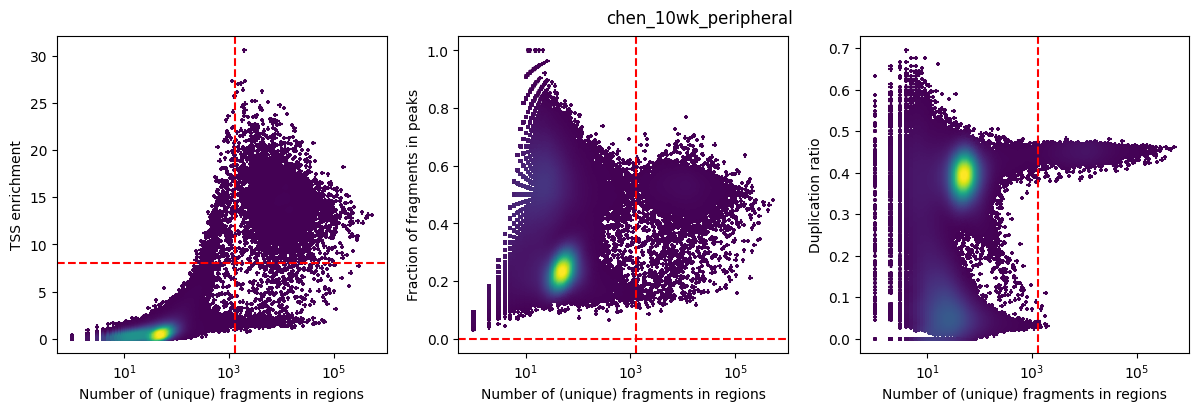

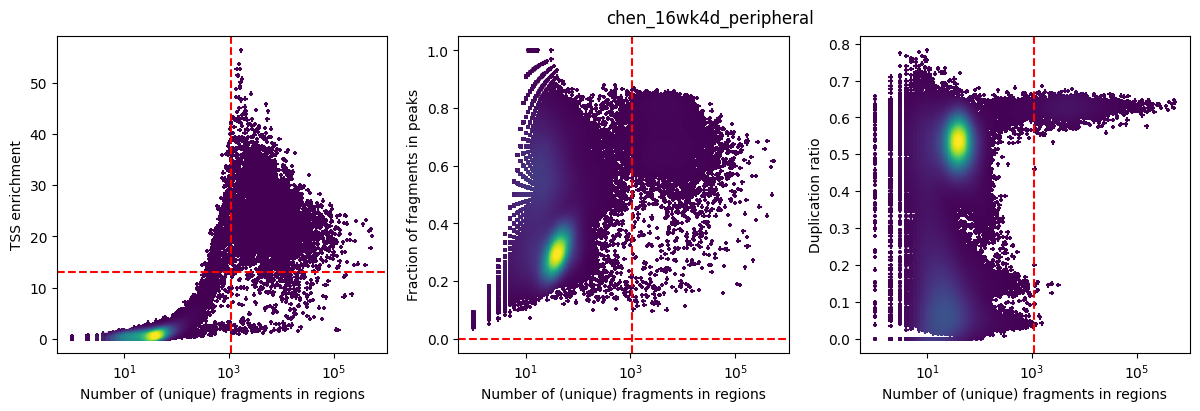

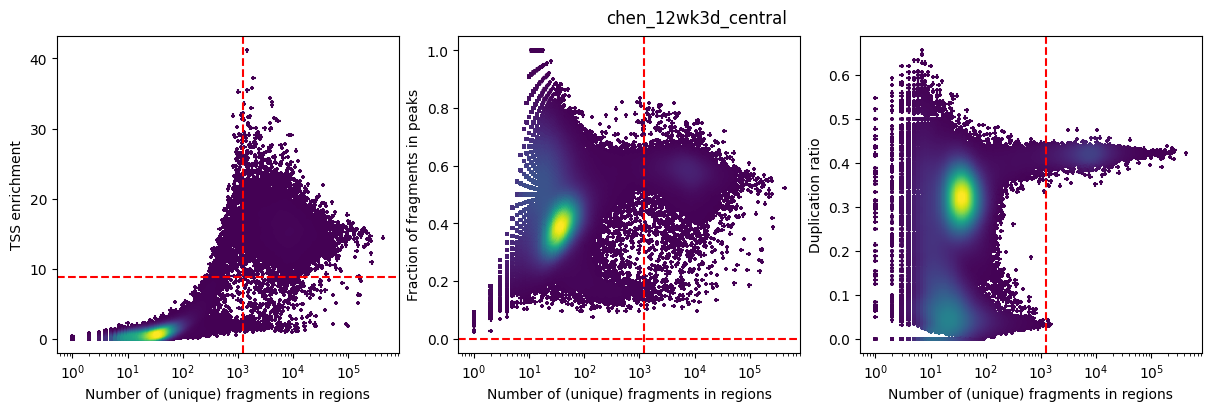

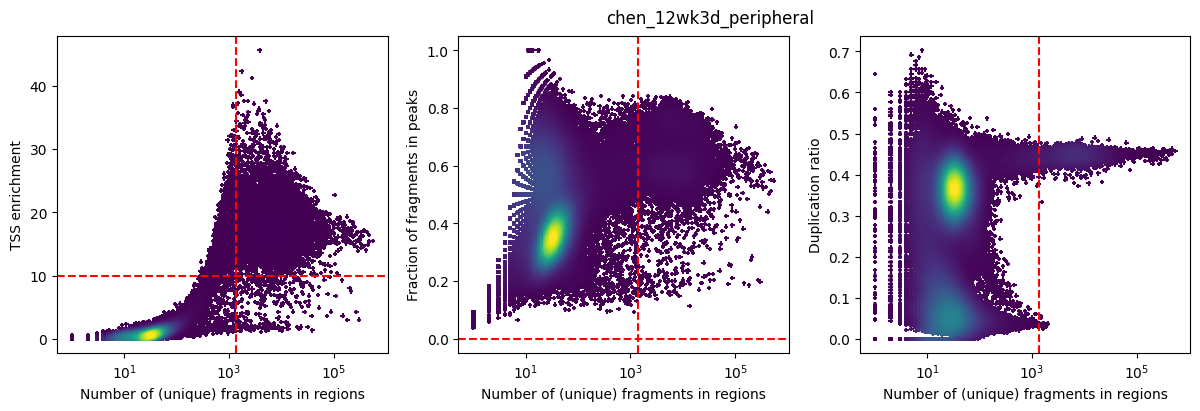

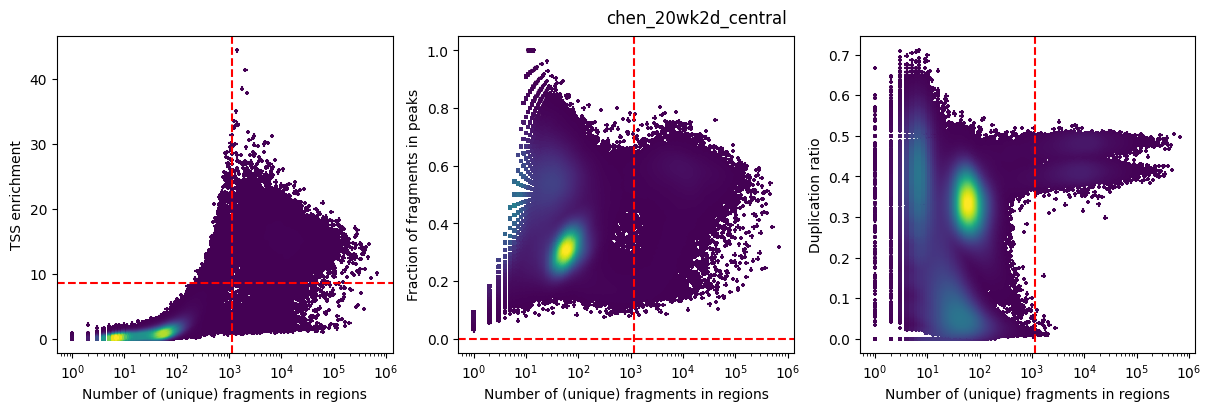

In [38]:
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id = sample_id,
        pycistopic_qc_output_dir = "chen_outs/qc",
        bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title = False,
        **sample_id_to_thresholds[sample_id]
    )

In [ ]:
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = "pycisTopic/blacklist/hg38-blacklist.v2.bed"
pycistopic_qc_output_dir = "chen_outs/qc"

from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import polars as pl

cistopic_obj_list = []
for sample_id in fragments_dict:
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[ sample_id_to_barcodes_passing_filters[sample_id] ]
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 1,
        project = sample_id,
        split_pattern = '_'
    )
    cistopic_obj_list.append(cistopic_obj)

2025-09-05 19:53:54,120 cisTopic     INFO     Reading data for chen_10wk_central
2025-09-05 19:55:36,854 cisTopic     INFO     metrics provided!
2025-09-05 19:55:45,265 cisTopic     INFO     Counting fragments in regions
2025-09-05 19:56:45,279 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 2796300430 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 19:57:47,399 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 19:57:59,552 cisTopic     INFO     Removing blacklisted regions
2025-09-05 19:58:01,014 cisTopic     INFO     Creating CistopicObject
2025-09-05 19:58:03,256 cisTopic     INFO     Done!
2025-09-05 19:58:04,593 cisTopic     INFO     Reading data for chen_20wk2d_peripheral
2025-09-05 20:01:34,452 cisTopic     INFO     metrics provided!
2025-09-05 20:01:50,337 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:04:01,530 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 7747679324 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:07:27,953 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:08:09,735 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:08:11,427 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:08:16,376 cisTopic     INFO     Done!
2025-09-05 20:08:17,637 cisTopic     INFO     Reading data for chen_16wk4d_central
2025-09-05 20:10:03,994 cisTopic     INFO     metrics provided!
2025-09-05 20:10:10,807 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:10:49,570 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 2249241264 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:11:29,956 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:11:39,481 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:11:40,953 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:11:42,596 cisTopic     INFO     Done!
2025-09-05 20:11:43,858 cisTopic     INFO     Reading data for chen_10wk_peripheral
2025-09-05 20:13:57,617 cisTopic     INFO     metrics provided!
2025-09-05 20:14:07,081 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:15:11,685 cisTopic     INFO     Creating fragment matrix
2025-09-05 20:16:10,909 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:16:20,652 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:16:22,149 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:16:24,311 cisTopic     INFO     Done!
2025-09-05 20:16:25,550 cisTopic     INFO     Reading data for chen_16wk4d_peripheral
2025-09-05 20:17:35,645 cisTopic     INFO    

/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 2305514112 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:18:54,304 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:19:04,039 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:19:05,477 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:19:07,060 cisTopic     INFO     Done!
2025-09-05 20:19:08,296 cisTopic     INFO     Reading data for chen_12wk3d_central
2025-09-05 20:21:01,740 cisTopic     INFO     metrics provided!
2025-09-05 20:21:09,666 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:22:10,692 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 3835560476 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:23:22,904 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:23:39,013 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:23:40,524 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:23:42,918 cisTopic     INFO     Done!
2025-09-05 20:23:44,192 cisTopic     INFO     Reading data for chen_12wk3d_peripheral
2025-09-05 20:25:49,956 cisTopic     INFO     metrics provided!
2025-09-05 20:25:58,838 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:27:11,677 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 3757284020 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:28:40,866 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:28:58,929 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:29:02,001 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:29:04,551 cisTopic     INFO     Done!
2025-09-05 20:29:07,844 cisTopic     INFO     Reading data for chen_20wk2d_central
2025-09-05 20:35:32,087 cisTopic     INFO     metrics provided!
2025-09-05 20:36:04,989 cisTopic     INFO     Counting fragments in regions
2025-09-05 20:39:30,869 cisTopic     INFO     Creating fragment matrix


/home/adrienne/mambaforge/envs/scenicplus_release/lib/python3.11/site-packages/pycisTopic/cistopic_class.py:886: PerformanceWarning: The following operation may generate 6442451019 cells in the resulting pandas object.
  .unstack(level="Name", fill_value=0)


2025-09-05 20:43:34,305 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-09-05 20:44:06,464 cisTopic     INFO     Removing blacklisted regions
2025-09-05 20:44:09,161 cisTopic     INFO     Creating CistopicObject
2025-09-05 20:44:14,454 cisTopic     INFO     Done!


In [40]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project chen_10wk_central with n_cells × n_regions = 5357 × 521990


In [48]:
cistopic_obj.cell_data['sample_id'][0]

'chen_10wk_central'

In [51]:
for i in cistopic_obj_list:
    pickle.dump(
        i,
        open(os.path.join(out_dir, f"{i.cell_data['sample_id'][0]}_cistopic_obj.pkl"), "wb")
    )

In [42]:
import pandas as pd
cell_data = mdata.obs
cell_data.head()
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [43]:
cistopic_obj.cell_data

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,barcode_rank,total_fragments_count,log10_total_fragments_count,unique_fragments_count,log10_unique_fragments_count,...,atac:scDblFinder_score,atac:scDblFinder_class,atac:_scvi_batch,atac:_scvi_labels,atac:leiden,sample,_indices,_scvi_batch,_scvi_labels,leiden
CGTTAGGTCTCCTCTT-1-chen_10wk_central,2850,3.454845,2667,3.426023,chen_10wk_central,5179,10776,4.032498,6018,3.779524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GGCAAGCCAGTAGGAT-1-chen_10wk_central,16663,4.221753,14369,4.157427,chen_10wk_central,1314,58837,4.769658,32065,4.506045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GGGCTAACAAATACCT-1-chen_10wk_central,3873,3.588047,3756,3.574726,chen_10wk_central,4747,13461,4.129110,7722,3.887786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACGGTACGTCAATAGT-1-chen_10wk_central,11447,4.058692,10217,4.009323,chen_10wk_central,2337,35601,4.551474,20487,4.311500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCAAACCAGTCACTAA-1-chen_10wk_central,48403,4.684872,38369,4.58398,chen_10wk_central,237,153351,5.185689,88179,4.945370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGCACTTAGTATTGCA-1-chen_10wk_central,2353,3.371622,2216,3.34557,chen_10wk_central,5582,8033,3.904932,4425,3.646011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CTACGAAGTCTTGCAT-1-chen_10wk_central,2233,3.348889,2090,3.320146,chen_10wk_central,5785,6617,3.820727,3606,3.557146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCAGCAACAGCTAATT-1-chen_10wk_central,1949,3.289812,1819,3.259833,chen_10wk_central,5634,7631,3.882638,4260,3.629512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AATAGAGGTTCGGTAA-1-chen_10wk_central,4976,3.69688,4435,3.646894,chen_10wk_central,4408,16150,4.208199,9107,3.959423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


!wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
!tar -xf Mallet-202108-bin.tar.gz

In [44]:
!mkdir -p mallet/chen/

In [45]:
os.environ['MALLET_MEMORY'] = '150G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu=12,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="mallet/chen/",
    save_path="mallet/chen/",
    mallet_path=mallet_path,
)

2025-09-05 20:44:40,313 cisTopic     INFO     Formatting input to corpus
2025-09-05 20:44:41,191 cisTopic     INFO     Running model with 2 topics
2025-09-05 20:44:41,205 LDAMalletWrapper INFO     Serializing temporary corpus to mallet/chen/corpus.txt
2025-09-05 20:45:11,300 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input mallet/chen/corpus.txt --output mallet/chen/corpus.mallet
2025-09-05 20:45:45,790 LDAMalletWrapper INFO     Training MALLET LDA with: Mallet-202108/bin/mallet train-topics --input mallet/chen/corpus.mallet --num-topics 2 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 12 --output-state mallet/chen/748536_state.mallet.gz --output-doc-topics mallet/chen/748536_doctopics.txt --output-topic-keys mallet/chen/748536_topickeys.txt --num-iterations 500 --inferencer-filename mallet/chen/748536_inferencer.mallet --doc-topics-threshold 0.0 --rando

KeyboardInterrupt: 

In [ ]:
pickle.dump(
    models,
    open(os.path.join(out_dir, "models.pkl"), "wb")
)

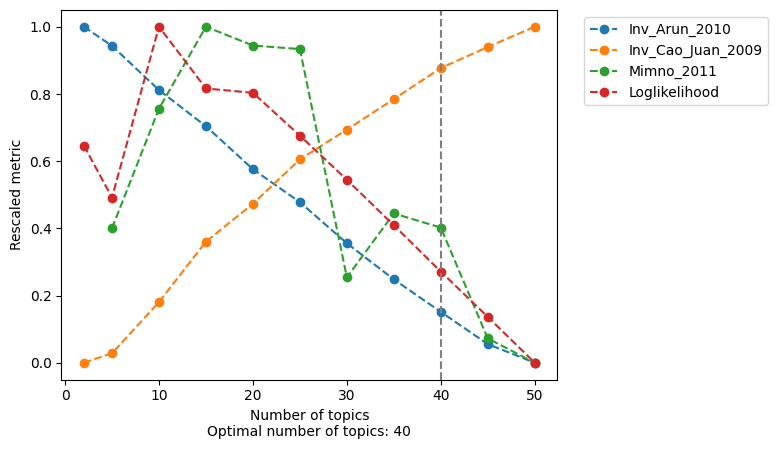

In [ ]:
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [ ]:
cistopic_list = []
with open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb") as f:
    cistopic_list.append(pickle.load(f))